### 5. Detecting the Anomalies


In this section, we'll cover different anomaly detection methods provided by SMADI. These methods compute anomalies based on the deviation from the climatology. The following anomaly detectors are available:

- ZScore
- SMAPI
- SMDI
- SMCA
- SMAD
- SMCI
- SMDS
- ESSMI
- ParaDis

For detailed information on how each index is computed, please refer to the [source code](https://github.com/MuhammedM294/smadi/blob/main/src/smadi/anomaly_detectors.py).

### Loading the data

In [1]:
import pandas as pd
from smadi.data_reader import read_grid_point
from smadi.anomaly_detectors import AnomalyDetectorFactory
from smadi.plot import plot_anomaly , plot_fill_bet

# Set display options
pd.set_option("display.max_columns", 8)  # Limit the number of columns displayed
pd.set_option("display.precision", 2)  # Set precision to 2 decimal places

# Define the path to the ASCAT data
data_path = "/home/m294/ascat_dataset"

# Example: A grid point in Morocco
lon = -7.382
lat = 33.348
gpid = 3611180

# Define the location of the observation point
loc = (lon, lat)

# Extract ASCAT soil moisture time series for the given location
data = read_grid_point(
    loc=loc, ascat_sm_path=data_path, read_bulk=False, era5_land_path=None
)  # Provide the path to the ERA5-Land data if you want mask snow
# and frozen soil conditions. For more information about
# the dataset see ERA5-Land data documentation and to download
# use the CDS API or https://ecmwf-models.readthedocs.io/en/latest/

# Get the ASCAT soil moisture time series
ascat_ts = data.get("ascat_ts")


# Display the first few rows of the time series data
ascat_ts.head()

Reading ASCAT soil moisture: /home/m294/ascat_dataset
ASCAT GPI: 3611180 - distance:   23.713 m


,sm,sm_noise,as_des_pass,ssf,...,sigma40,sigma40_noise,num_sigma,sm_valid
2007-01-01 21:02:04.161,34.86,3.24,0,0,...,-12.27,0.19,3,True
2007-01-02 11:03:22.807,23.16,3.27,1,0,...,-13.05,0.19,3,True
2007-01-03 10:42:47.739,33.05,3.23,1,0,...,-12.39,0.19,3,True
2007-01-03 22:00:39.007,25.60,3.24,0,0,...,-12.88,0.19,3,True
2007-01-05 10:01:27.519,28.73,3.24,1,0,...,-12.67,0.19,3,True


#### 5.1 Zscore Usage Example

In [2]:
# Create a ZScore anomaly detector object

zscore_detector = AnomalyDetectorFactory.create_detector(
    "zscore",  # Anomaly detection method
    df=ascat_ts,  # DataFrame containing the time series data
    variable="sm",  # Variable of interest (e.g., "sm" for soil moisture)
    fillna=True,  # Fill missing values (NaNs) in the data
    fillna_window_size=3,  # Window size for filling missing values
    smoothing=True,  # Smooth the data before anomaly detection
    smooth_window_size=31,  # Window size for smoothing
    time_step="month",  # Time step for computing anomalies (e.g., "month")
)

# Detect anomalies using ZScore method
zscore_df = zscore_detector.detect_anomaly()
zscore_df

,sm-mean,norm-mean,zscore
2007-01-31,32.86,56.12,-1.70
2007-02-28,36.60,47.10,-0.81
2007-03-31,27.14,36.68,-0.83
2007-04-30,28.36,33.51,-0.48
2007-05-31,24.64,28.28,-0.29
...,...,...,...
2022-08-31,16.84,18.03,-0.32
2022-09-30,17.80,21.79,-1.00
2022-10-31,22.79,31.37,-1.20
2022-11-30,39.96,49.91,-0.86


#### Plot the anomalies

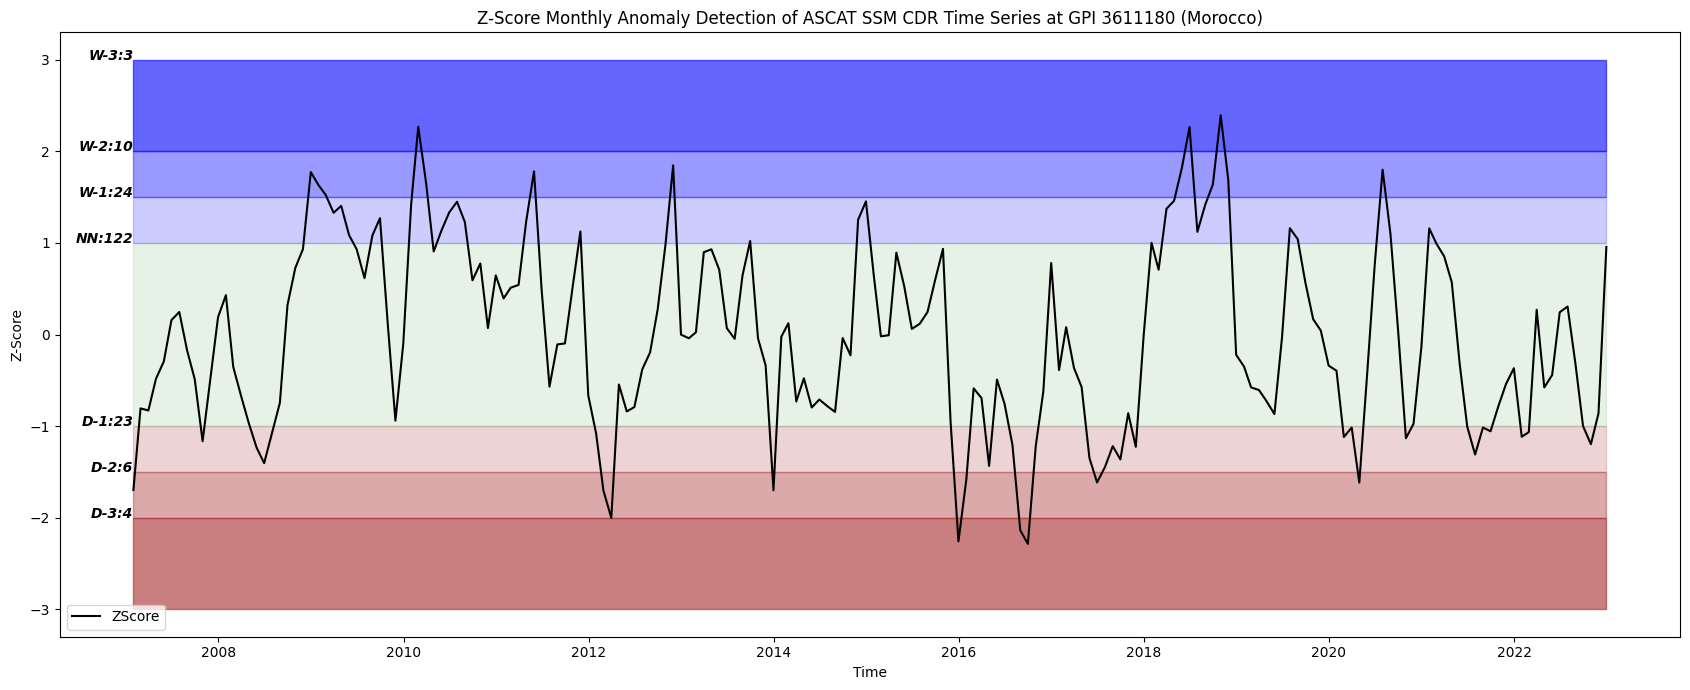

In [3]:
colm = {"zscore": {"color": "black", "linewidth": 1.5, "label": "ZScore"}}
plot_anomaly(
    zscore_df,
    zscore_df.index,
    colmns=colm,
    thresholds="zscore",  # For each method thresholds, refer to the source code: smadi.metadata
    plot_hbars=True,
    plot_categories=True,  # Whether to plot the number of anomalies detected in each category
    figsize=(17, 7),
    grid=False,
    legend=True,
    xlabel="Time",
    ylabel="Z-Score",
    title=f"Z-Score Monthly Anomaly Detection of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)

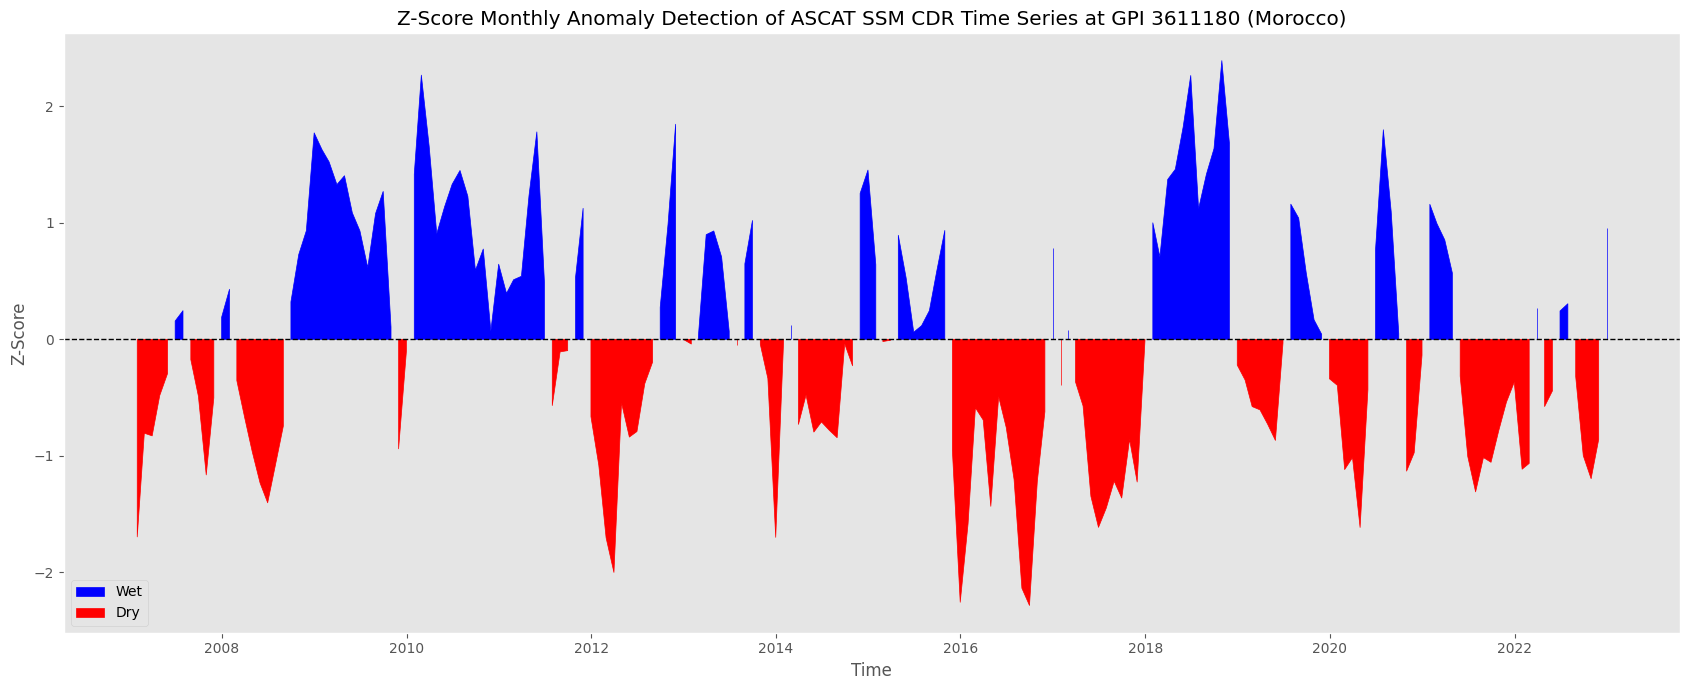

In [4]:
plot_fill_bet(
    zscore_df,
    zscore_df.index,
    colmn="zscore",  # Column to plot
    figsize=(17, 7),
    grid=False,
    legend=True,
    xlabel="Time",
    ylabel="Z-Score",
    title=f"Z-Score Monthly Anomaly Detection of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)

#### 5.2 SMAPI Usage Example

In [5]:
smapi_detector = AnomalyDetectorFactory.create_detector(
    "smapi",
    df=ascat_ts,
    variable="sm",
    fillna=True,
    fillna_window_size=3,
    smoothing=True,
    smooth_window_size=31,
    time_step="month",
    normal_metrics=["mean", "median"],
)

smapi_df = smapi_detector.detect_anomaly()
smapi_df['smapi-mean'] = smapi_df['smapi-mean'].clip(lower = -50 , upper=50)
smapi_df

,sm-mean,norm-mean,norm-median,smapi-mean,smapi-median
2007-01-31,32.86,56.12,55.68,-41.44,-40.98
2007-02-28,36.60,47.10,47.13,-22.29,-22.35
2007-03-31,27.14,36.68,34.54,-26.00,-21.41
2007-04-30,28.36,33.51,28.39,-15.36,-0.08
2007-05-31,24.64,28.28,23.65,-12.88,4.21
...,...,...,...,...,...
2022-08-31,16.84,18.03,17.50,-6.59,-3.78
2022-09-30,17.80,21.79,22.43,-18.33,-20.67
2022-10-31,22.79,31.37,31.59,-27.33,-27.85
2022-11-30,39.96,49.91,45.05,-19.94,-11.31


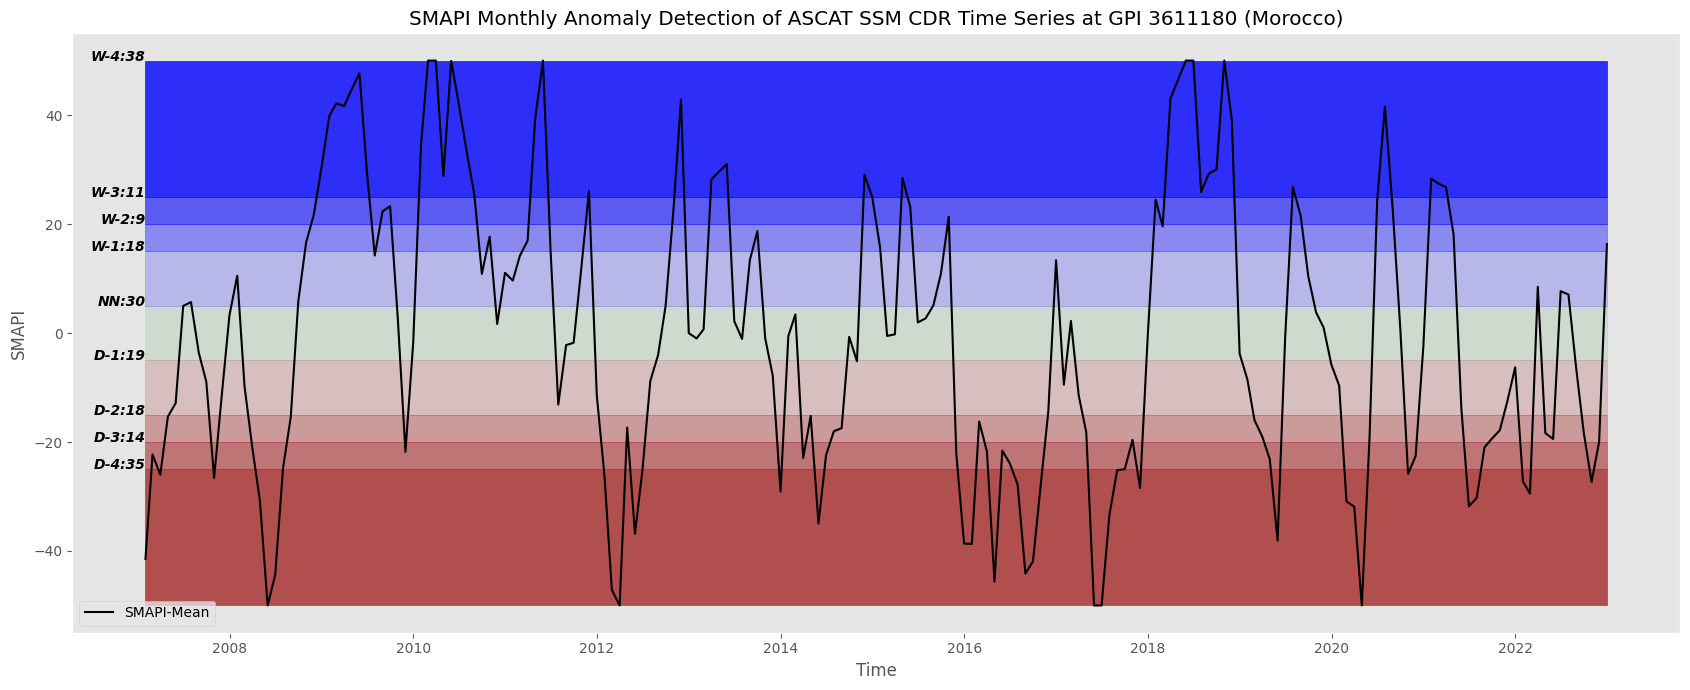

In [6]:
colm = {"smapi-mean": {"color": "black", "linewidth": 1.5, "label": "SMAPI-Mean"}}


plot_anomaly(
    smapi_df,
    smapi_df.index,
    colmns=colm,
    thresholds="smapi",  # For each method thresholds, refer to the source code: smadi.metadata
    plot_hbars=True,
    plot_categories=True,  # Whether to plot the number of anomalies detected in each category
    figsize=(17, 7),
    grid=False,
    legend=True,
    xlabel="Time",
    ylabel="SMAPI",
    title=f"SMAPI Monthly Anomaly Detection of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)

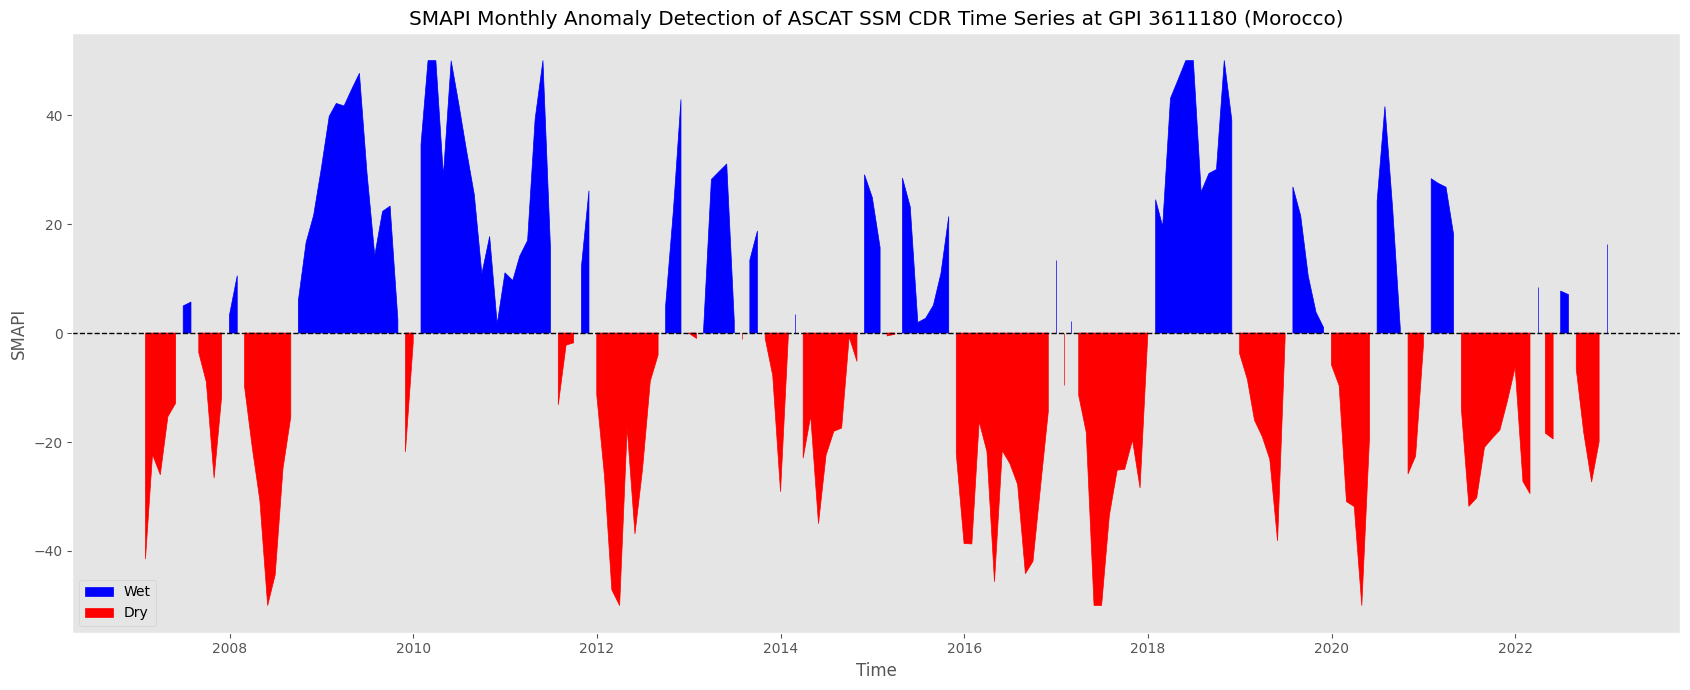

In [7]:
plot_fill_bet(
    smapi_df,
    smapi_df.index,
    colmn="smapi-mean",  # Column to plot
    figsize=(17, 7),
    grid=False,
    legend=True,
    xlabel="Time",
    ylabel="SMAPI",
    title=f"SMAPI Monthly Anomaly Detection of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)

#### 5.3 ParaDis Usage Example

##### Parametric Distribution: Gamma and Beta

In [10]:
paradis_detector = AnomalyDetectorFactory.create_detector(
    "paradis",
    df=ascat_ts,
    variable="sm",
    fillna=True,
    fillna_window_size=3,
    smoothing=True,
    smooth_window_size=31,
    time_step="month",
    dist=["beta", "gamma"],
)

para_dist_df = paradis_detector.detect_anomaly()
para_dist_df

,sm-mean,norm-mean,beta,gamma
2007-01-31,32.86,56.12,-3.00,-1.72
2007-02-28,36.60,47.10,-0.31,-0.77
2007-03-31,27.14,36.68,-0.49,-0.83
2007-04-30,28.36,33.51,-0.26,-0.47
2007-05-31,24.64,28.28,-0.60,0.03
...,...,...,...,...
2022-08-31,16.84,18.03,-0.71,-0.30
2022-09-30,17.80,21.79,-0.52,-0.97
2022-10-31,22.79,31.37,-1.70,-1.65
2022-11-30,39.96,49.91,-0.38,-0.56


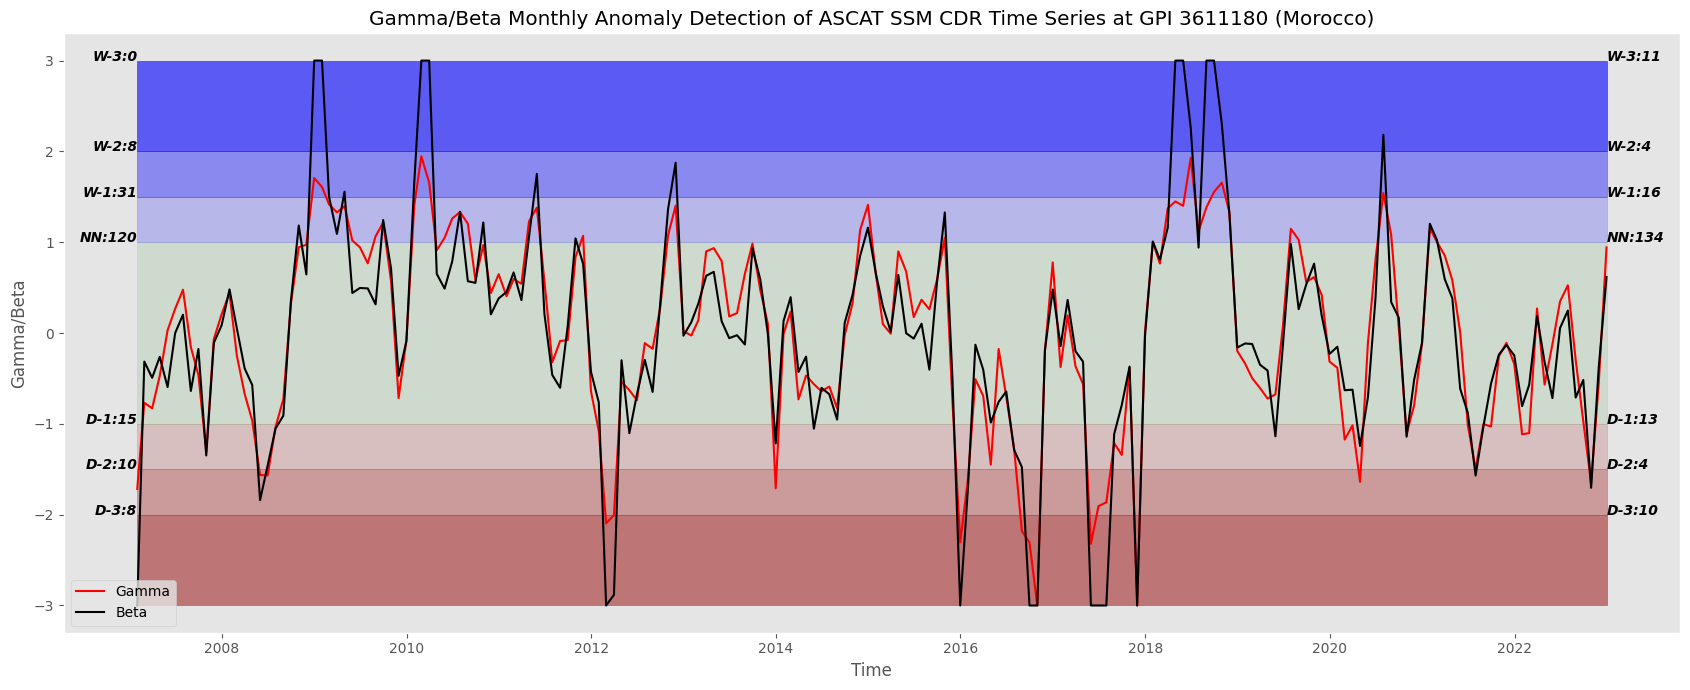

In [11]:
colm = {
    "gamma": {"color": "red", "linewidth": 1.5, "label": "Gamma"},
    "beta": {"color": "black", "linewidth": 1.5, "label": "Beta"},
}

plot_anomaly(
    para_dist_df,
    para_dist_df.index,
    colmns=colm,
    thresholds="gamma",  # For each method thresholds, refer to the source code: smadi.metadata
    plot_hbars=True,
    plot_categories=True,  # Whether to plot the number of anomalies detected in each category
    figsize=(17, 7),
    grid=False,
    legend=True,
    xlabel="Time",
    ylabel="Gamma/Beta",
    title=f"Gamma/Beta Monthly Anomaly Detection of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)

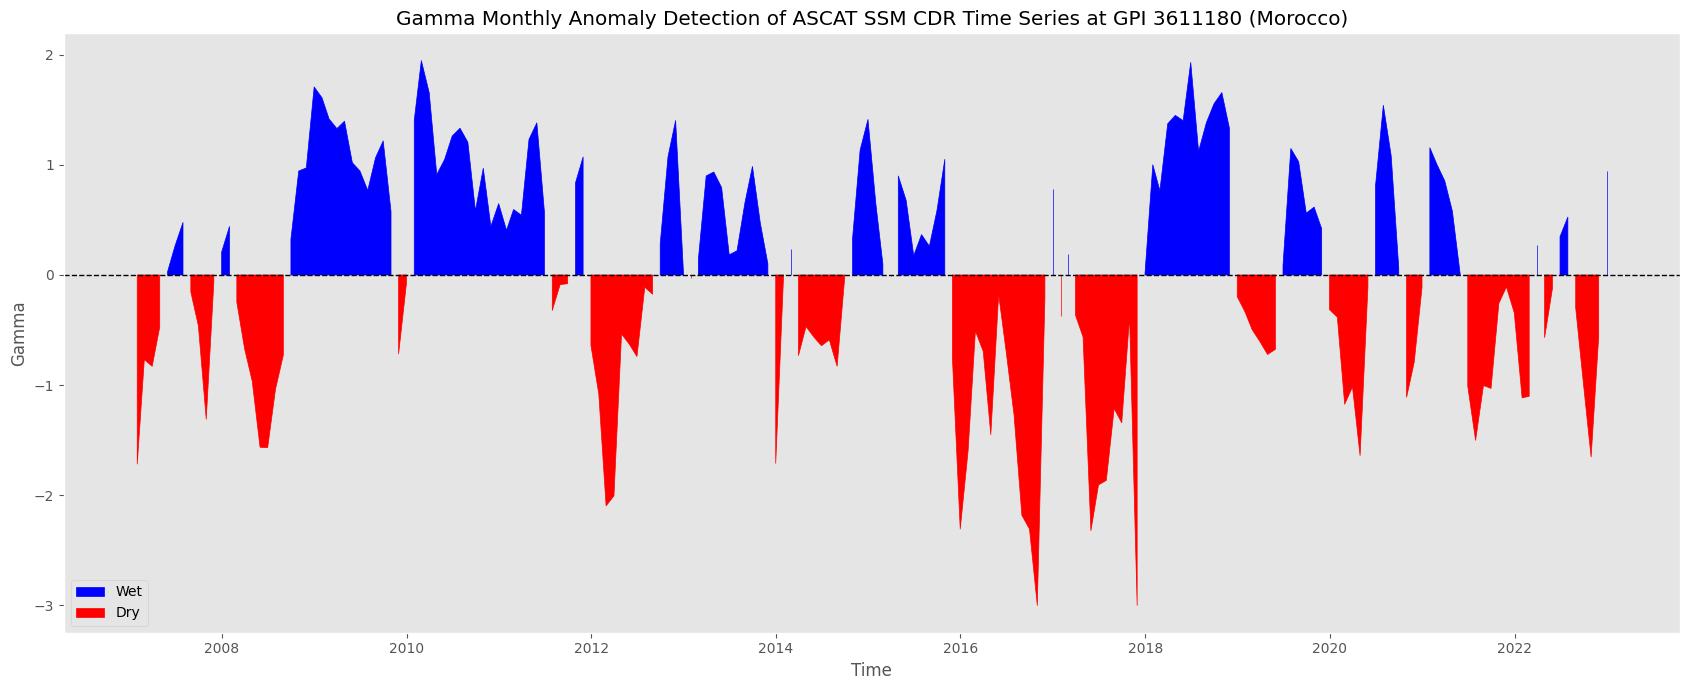

In [12]:
plot_fill_bet(
    para_dist_df,
    para_dist_df.index,
    colmn="gamma",  # Column to plot
    figsize=(17, 7),
    grid=False,
    legend=True,
    xlabel="Time",
    ylabel="Gamma",
    title=f"Gamma Monthly Anomaly Detection of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)

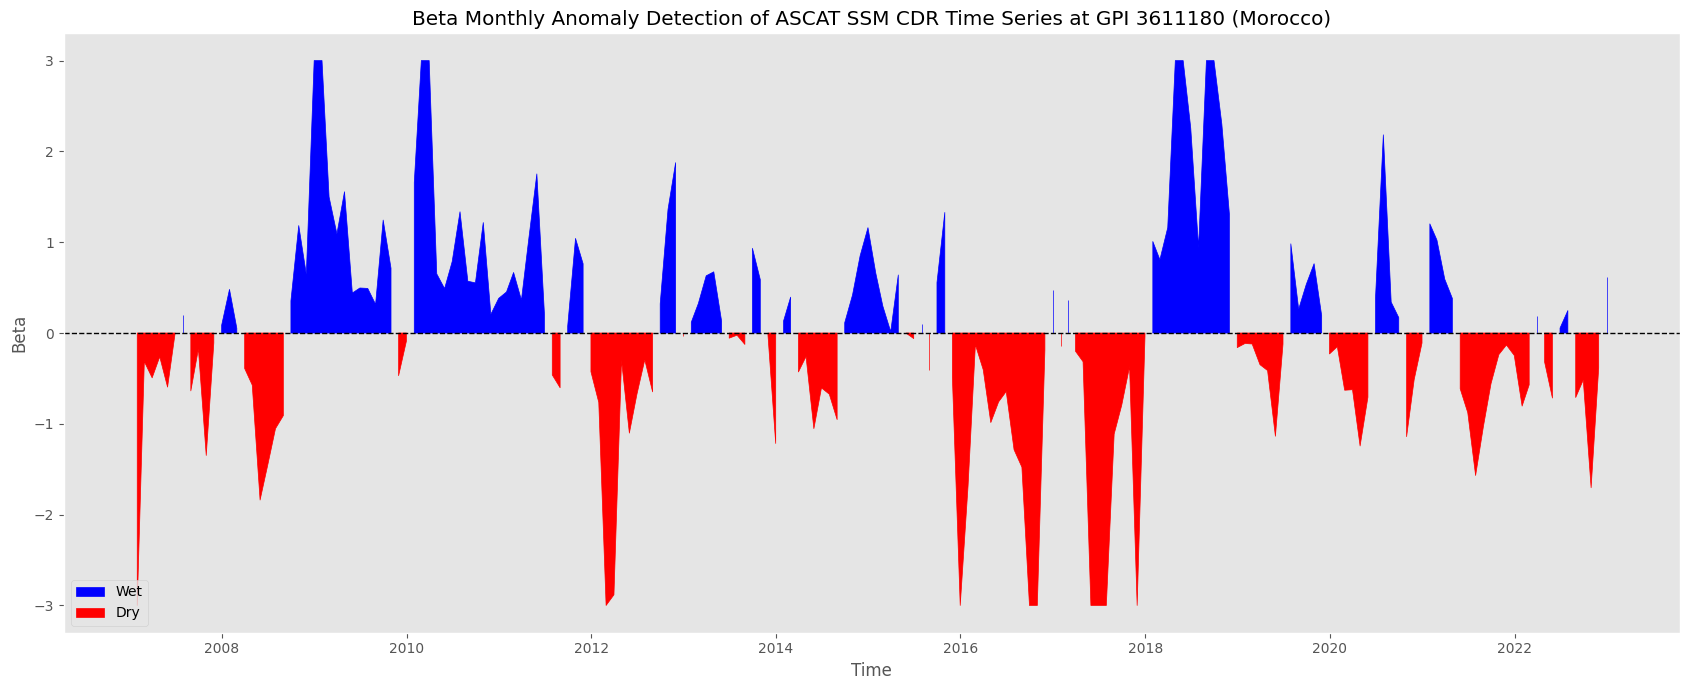

In [13]:
plot_fill_bet(
    para_dist_df,
    para_dist_df.index,
    colmn="beta",  # Column to plot
    figsize=(17, 7),
    grid=False,
    legend=True,
    xlabel="Time",
    ylabel="Beta",
    title=f"Beta Monthly Anomaly Detection of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)

#### 5.4 ESSMI Usage Example


In [14]:
essmi_detector = AnomalyDetectorFactory.create_detector(
    "essmi",
    df=ascat_ts,
    variable="sm",
    fillna=True,
    fillna_window_size=3,
    smoothing=True,
    smooth_window_size=31,
    time_step="month",
)

essmi_df = essmi_detector.detect_anomaly()
essmi_df

,sm-mean,norm-mean,essmi
2007-01-31,32.86,56.12,-1.40
2007-02-28,36.60,47.10,-0.66
2007-03-31,27.14,36.68,-0.67
2007-04-30,28.36,33.51,-0.30
2007-05-31,24.64,28.28,-0.10
...,...,...,...
2022-08-31,16.84,18.03,-0.26
2022-09-30,17.80,21.79,-0.85
2022-10-31,22.79,31.37,-0.99
2022-11-30,39.96,49.91,-0.65


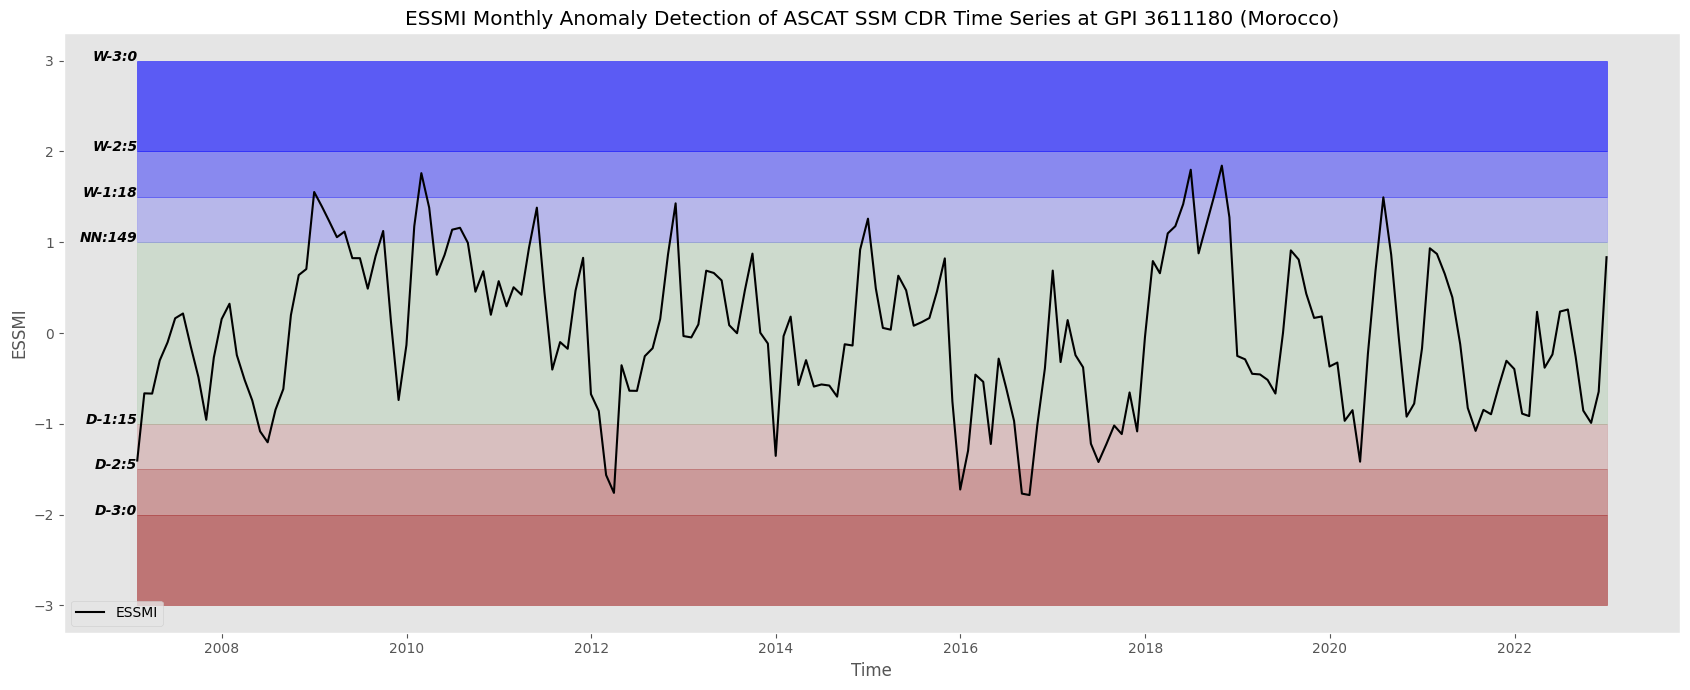

In [15]:
colm = {"essmi": {"color": "black", "linewidth": 1.5, "label": "ESSMI"}, 
        }

plot_anomaly(
    essmi_df, 
    essmi_df.index, 
    colmns=colm,
    thresholds="essmi", # For each method thresholds, refer to the source code: smadi.metadata 
    plot_hbars=True,
    plot_categories=True, # Whether to plot the number of anomalies detected in each category
    figsize=(17, 7),
    grid=False,
    legend=True,
    xlabel="Time",
    ylabel="ESSMI",
    title=f"ESSMI Monthly Anomaly Detection of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)

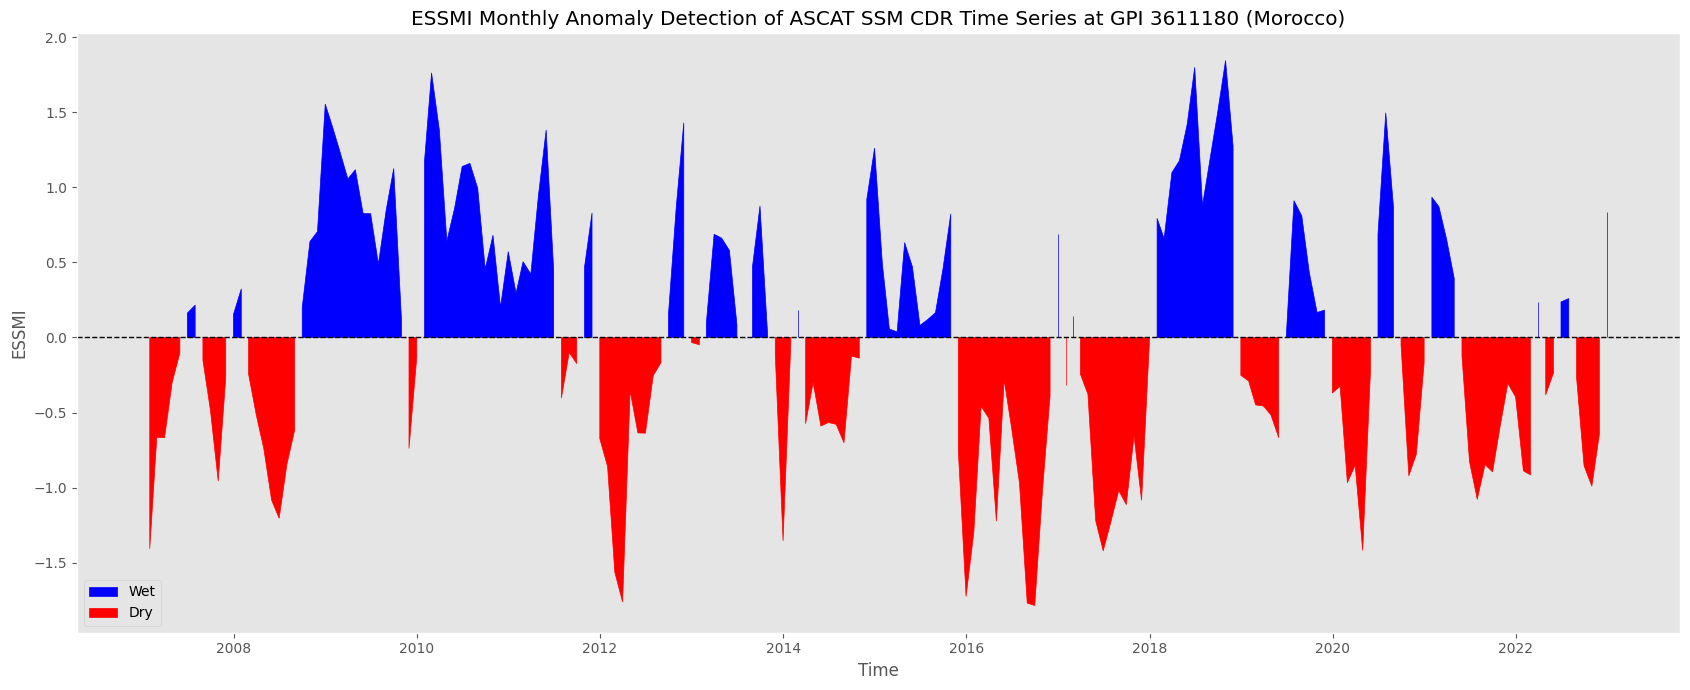

In [16]:
plot_fill_bet(
    essmi_df,
    essmi_df.index,
    colmn="essmi",  # Column to plot
    figsize=(17, 7),
    grid=False,
    legend=True,
    xlabel="Time",
    ylabel="ESSMI",
    title=f"ESSMI Monthly Anomaly Detection of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)